<a href="https://colab.research.google.com/github/adryduty/computer-vision-cat-project/blob/main/Preprocessing_comp_vision_cat_24_June_ipnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color = 'red'> **This is GHIRI**

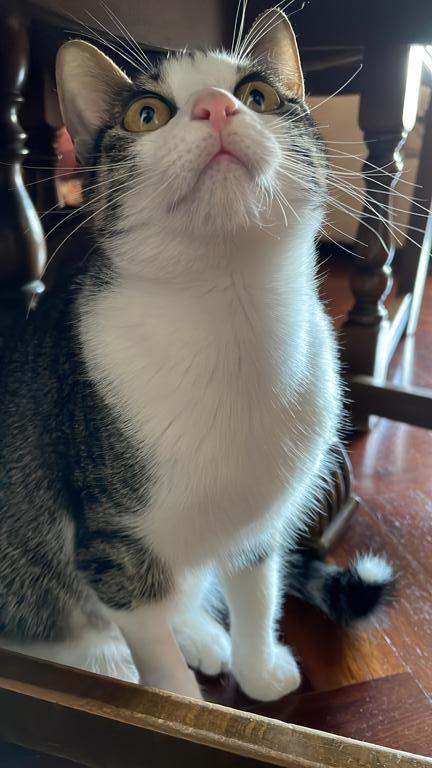


<font color = 'red'>**Ghiri loves chilling on the balcony.** </font><br> 
<font color = 'red'> **Problem** </font>: Ghiri doesn't understand how dangerous it could be and she believes she can fly. <br>
<font color = 'red'> **Solution**:</font> A normal person would just forbid her to go out, **BUT**, as data scientists we decided to implement a Ghiri detector which can play a sound when Ghiri gets nearby the window. <br>
With that said, let's go deep into the code! 

<font color = 'red'> **ENJOY** </font>

#### We will organize our workflow in three steps (three notebooks):

* Preprocessing
* Training the neural network
* Evaluate the neural network

# <font color = red> **REFERENCES** </font>

1. https://github.com/ultralytics/yolov5

2. https://arxiv.org/pdf/1506.02640.pdf

3. https://colab.research.google.com/drive/1xdjyBiY75MAVRSjgmiqI7pbRLn58VrbE?usp=sharing

4. https://medium.com/mlearning-ai/training-yolov5-custom-dataset-with-ease-e4f6272148ad

# <font color='red'> **PREPROCESSING**

#### **This step (preprocessing) consists in taking the pictures, labelling them and we conclude gathering the whole output in a single csv file.**


#### **Here we import the modules needed just for this step**.

In [ ]:
import numpy as np 
import pandas as pd
from PIL import Image 
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.patches as patches
import time
from google.colab import files
import os
import shutil

* **numpy:** to deal with arrays
* **pandas:** to deal with data frames (filtering, selecting, sorting, grouping, etc.)
* **PIL.Image:** to open, manipulate and save many different image file formats
* **matplotlib.pyplot & matplotlib.ticker:** to display a grid on each picture (more details later on)
* **matplotlib.patches:** to display a red bounding box according to input (more details later on) the user provides
* **time:** to set the sleep time to perform the action in the correct order
* **google.colab.files:** to create a zip
* **os:** to create folders
* **shutil:** to move files from one folder to another

#### Our dataset is composed by pictures taken with the following functions. If you want to use these functions too, you'll need to load other modules (the ones in the next chunk)

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import io

## Here we are going to create some functions to take and save photos and to use them as input

### All the lines of code there are here need to be run just one time (after that you just work with the pictures you saved).

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  '''
  This function creates a javascript function that takes a picture every 4 seconds. 
  After that it displays the taken picture in the quality determined as argument (quality. Default = 0.8), decode the picture in Base64 (binary) 
  and eventually RETURNS THE PICTURE IN BINARY.
  '''
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      
      await new Promise(r => setTimeout(r, 4000)); // 4000 milliseconds to wait

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  return binary

In [ ]:
def binary_to_numpy(binary):
  '''
  This function takes a picture coded in binary and transforms it as numpy array.
  '''
  img = Image.open(io.BytesIO(binary))
  np_array = np.asarray(img)
  return np_array

* Assign an empty list to **photo_array** (here you will append the numpy arrays of the pictures);
* Decide how many pictures to take and assign this number to **num_of_pictures_to_take**;
* Iterate num_of_pictures_to_take times and every time append the taken picture (in numpy array) in the photo_array.
* If the user doesn't have a webcam or if he doesn't grant the page permission to access it, return an error.

In [ ]:
photo_array = []
num_of_pictures_to_take = 5

for i in range(num_of_pictures_to_take):
  try:
    
    binary = take_photo()
    photo_array.append(binary_to_numpy(binary))
    
  except Exception as err:
    print(str(err))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Display all the images stored in photo_array.
for e in photo_array:
  display(Image.fromarray(e))

## Labelling (bounding box)
### The idea is to create a n_cells$*$n_cells grid on the image to choose the rectangle around Ghiri (you just need to choose the upper left square and the bottom right square).

In [ ]:
def label_maker(upper_left, bottom_right, n_cells):
  '''
  CONSIDER THAT YOU HAVE A n_cells*n_cells MATRIX AND THAT THE PIXELS ARE NORMALIZED TO 1 (they go from 0 to 1)

  This function takes the upper left and the bottom right squares as input and returns:
  - 0 (indicating the class: here is just 0 because we have just Ghiri)
  - x_c (x coordinate of the center of the bounding box)
  - y_c (x coordinate of the center of the bounding box)
  - Width of the bounding box
  - Height of the buonding box
  '''
  if bottom_right < 0 or upper_left < 0 or bottom_right >= n_cells*n_cells or upper_left >= n_cells*n_cells:
    print('Wrong input: insert a valid integer')
    return (0,0,0,0,0)

  elif (bottom_right % n_cells) < (upper_left % n_cells): # To check if bottom_right is (wrong) at the left of upper_left (e.g. if n_cells=10, then upper_left=15 and bottom_right=43 would return an error: (15%10=5) > (43%10=3))
    print("Wrong input: bottom_right is at the left of upper_left")
    return (0,0,0,0,0)
    
  elif (upper_left // n_cells) > (bottom_right // n_cells): # To check if upper_left is (wrong) below bottom_right (e.g. if n_cells=10, then upper_left=43 and bottom_right=15 would return an error (43//10=4)>(15//10=1))
    print("Wrong input: upper_left is below bottom_right")
    return (0,0,0,0,0)

  else:
    num_squares_height = 1 + (bottom_right - upper_left) // n_cells
    height = num_squares_height / n_cells

    num_squares_width = 1 + (bottom_right - upper_left) % n_cells
    width = num_squares_width / n_cells 
    x_a = (upper_left % n_cells + 0.5) / n_cells # upper left x coordinate
    y_a = (upper_left // n_cells + 0.5) / n_cells # upper left y coordinate

    x_b = (bottom_right % n_cells + 0.5) / n_cells # bottom right x coordinate
    y_b = (bottom_right // n_cells + 0.5) / n_cells # bottom right x coordinate

    x_c = (x_a + x_b)/2 
    y_c = (y_a + y_b)/2

    return 0, x_c, y_c, width, height 


In [ ]:
def grid_image(google_path_image):
  '''
  This function takes as INPUT the google path of the image you want to apply the grid onto.

  It is a non fruitful function and it displays the picture with the grid and numbers in each square of grid on it.
  '''
  # Open image file
  img = Image.open(google_path_image)
  my_dpi=416.

  img = img.resize(size=(416, 416))

  # Set up figure
  fig=plt.figure(figsize=(float(img.size[0])/my_dpi,float(img.size[1])/my_dpi),dpi=my_dpi)
  ax=fig.add_subplot(111)

  # Remove whitespace from around the image
  fig.subplots_adjust(left=0,right=1,bottom=0,top=1)

  # Set the gridding interval: here we use the major tick interval
  myInterval= 20.8                                        # interval of each little square
  loc = plticker.MultipleLocator(base=myInterval)         # Set a tick on each integer multiple of a base within the view interval.
  ax.xaxis.set_major_locator(loc)                         # Create a grid on the basis of the ticks of the x axis.
  ax.yaxis.set_major_locator(loc)                         # Create a grid on the basis of the ticks of the y axis.

  ax.tick_params(axis='x', colors=(0,0,0,0))
  ax.tick_params(axis='y', colors=(0,0,0,0))

  # Remove the borders 
  ax.spines['top'].set_visible(False) 
  ax.spines['right'].set_visible(False) 
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)

  # Add the grid
  ax.grid(which='major', axis='both', linestyle='-', linewidth=0.1)

  # Add the image
  ax.imshow(img)

  # Find number of gridsquares in x and y direction
  nx=abs(int(float(ax.get_xlim()[1]-ax.get_xlim()[0])/float(myInterval)))
  ny=abs(int(float(ax.get_ylim()[1]-ax.get_ylim()[0])/float(myInterval)))

  # Add numbers in the squares
  for j in range(ny):
      y=myInterval/2+j * myInterval
      for i in range(nx):
          x=myInterval/2.+float(i) * myInterval
          ax.text(x,y,'{:d}'.format(i+j*nx),color='w',ha='center',va='center', fontsize=1.4)

  plt.show()



**The output of label_maker function is used in the next function that sets the coordinates of each bounding box.**


In [ ]:
def rectangle_coordinates(x_c, y_c, width, height):
  '''
  - Input: This function takes the coordinates of the rectangle's center and the width and the height of a
  rectangle

  - Output: it returns the coordinates of the rectangle's bottom left angle and the width and the height
  multiplied by 416. 
  '''

  x_bottom_left_angle = (x_c - width/2)*416

  y_bottom_left_angle = (y_c - height/2)*416

  width = width * 416

  height = height * 416

  return x_bottom_left_angle, y_bottom_left_angle, width, height



In [ ]:
def rectangle_maker(google_path_image, x_c, y_c, width, height):
  '''
  - Input: This function (which is a non fruitful one) takes a picture saved in colab, the coordinates of the centers of a rectangle, its width and its height.

  - Output: It displays the image with the rectangle around Ghiri (according to the provided input) and also saves it on colab
  '''

  im = Image.open(google_path_image)
  im = im.resize(size=(416,416))

  # Create figure and axes
  fig, ax = plt.subplots()
  
  x_left_angle, y_left_angle, denorm_width, denorm_height = rectangle_coordinates(x_c, y_c, width, height)
  
  # Create a Rectangle patch
  rect = patches.Rectangle((x_left_angle, y_left_angle), denorm_width, denorm_height, linewidth=1, edgecolor='r', facecolor='none')

  # Add the patch to the Axes
  ax.add_patch(rect)

  ax.tick_params(axis='x', colors=(0,0,0,0))
  ax.tick_params(axis='y', colors=(0,0,0,0))

  # Remove the borders 
  ax.spines['top'].set_visible(False) 
  ax.spines['right'].set_visible(False) 
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)

  # Display the image
  ax.imshow(im)

  plt.savefig('/' + google_path_image.split("/")[1]+'/with_rectangle_'+google_path_image.split("/")[2])


**The following function allows the user to insert the upper left and the bottom right squares to make the rectangles and so FOR LABELING. To do so, it leverages all the functions created above.**

Each label will be an array **[google_path, label, x_c, y_c, width, height]**

In [ ]:
def labeler(path_list):
  '''
  - Input: a list containing the google colab paths of each image to label

  It displays you the image to label with the grid on it (from grid_image function); the user inserts the upper left 
  square and the bottom right square; if no mistakes are made, the user will see the image with the bouding box on it (from rectangle_maker function).

  - Output: an array in this form [google_path, label, x_c, y_c, width, height] (from label_maker function)
  '''
  label_list = []

  for path in path_list:
    grid_image(path)
    time.sleep(3)
    print(path)
    try: 
      upper_left = int(input("insert upper left square: "))
      bottom_right = int(input("insert bottom right square: "))

      label, x_c, y_c, width, height = label_maker(upper_left, bottom_right, 20)
    except:
      (label, x_c, y_c, width, height) = (0,0,0,0,0)

    # If you make a mistake (the two in the label_maker function), you will be warned, in order to label again (you can do it just at the end)
    if (label, x_c, y_c, width, height) == (0,0,0,0,0):
      print("You have to label again this image:", path)

    label_list.append([path, label, x_c, y_c, width, height])
    rectangle_maker(path, x_c, y_c, width, height)

  return label_list

In [ ]:
def error_corrector():
  '''
  This function allows you to re-label the pictures you have labeled wrong.
  
  When you run it, you'll be asked to print the google path of all the pictures you want to change the label of. 
  When you have printed all the path of the pictures you have to relabel, print stop and then you can start re-labelling all these pictures.

  When you think you're done, print stop.
  '''
  images = []
  print("Insert the path of those you're not satisfied with. Write 'stop' once you're done")
  image = input('Insert the path or stop if you have finished: ')
  while image.lower() != 'stop':
    images.append(image)
    image = input("Insert the path or stop if you have finished: ")

  for single_image in images:
    new_image = labeler([single_image]) # labeler wants a list of strings as input
    label_list.append(new_image[0]) # append the list of the re-labeled image (notice that new_image is a list with a list inside of it and you want the inner list)
  
  return label_list

In [ ]:
def df_creator(label_list):
  '''
  - Input: the output of either labeler or error_corrector (a list of lists where the elements of the inner lists are
            [google_path, label, x_c, y_c, width, height] ) 

  - Output: csv file with the labels
  '''
  # Create a dataframe with columns: ['google_path', 'label', 'x_c', 'y_c', 'width', 'height']; rows: the picture; the values are the labels.
  label_dataframe = pd.DataFrame(label_list, columns = ['google_path', 'label', 'x_c', 'y_c', 'width', 'height'])

  # There are some duplicates. Let's drop them. We want to keep only the last image.
  label_dataframe = label_dataframe.drop_duplicates(subset=["google_path"], keep='last', ignore_index=True)

  # Save the dataframe in csv on colab
  label_dataframe.to_csv('/content/label_dataframe.csv', index = False )

In **path_list** will be stored all the paths of each image to label.

In [ ]:
path_list = []

for n in range(184,186):
 path_list.append("/content/img" + str(n) + ".jpg")

In [ ]:
# Create the list with all the labels
label_list = labeler(path_list) 

#### If you need to re-label some picture, you can use error_corrector()

In [ ]:
error_corrector()

#### Run the following chunk, in order to save all the labels in a csv file

In [ ]:
df_creator(label_list)

#### Eventually, we store the csv in a zip file that we need to make the training part working.

In [ ]:
label_dataframe = pd.read_csv('label_dataframe.csv')

In [ ]:
for i in range(len(label_dataframe)):
  file_name = label_dataframe.google_path[i].split('.')[0] + '.txt'
  np.savetxt(file_name, list(label_dataframe.iloc[i, 2:]),fmt = '%.2f', newline = ' ', header = '0', comments = '') 

In [ ]:
os.makedirs('/content/archive/')

In [ ]:
def file_path_changer(source, dest): 
  '''
  This function moves the files from the path 'source' to the path 'dest'
  '''
  shutil.move(source, dest)

In [ ]:
for i in range(1,235):
  file_path_changer('/content/img'+str(i)+'.txt', '/content/archive/')
  file_path_changer('/content/img'+str(i)+'.jpg', '/content/archive/')

In [ ]:
!zip -r /content/file.zip /content/archive

In [ ]:
files.download('/content/file.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>